In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graspy.inference import SemiparametricTest
from graspy.embed import AdjacencySpectralEmbed, select_dimension
import seaborn as sns
import warnings
from graspy.simulations import binary_sbm, rdpg_from_latent
from graspy.utils import symmetrize
import time
import pandas as pd


warnings.filterwarnings("ignore")
FONTSIZE = 30

def double_plot(A, X):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    sns.heatmap(A, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    sns.scatterplot(X[:,1], X[:,2], ax=ax[1],alpha = 0.5,s=100)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[0].set_title('Adjacency matrix', fontsize=FONTSIZE)
    ax[1].set_title('Adjacency spectral embedding',fontsize=FONTSIZE)
    return ax

def adj_plot(A, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(A, ax=ax, xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    if title is None: 
        title = 'Adjacency matrix'
    ax.set_title(title, fontsize=FONTSIZE)
    return ax

# From *A Semiparametric Two-Sample Hypothesis Testing Problem for Random Graphs* (Tang et al. 2017)

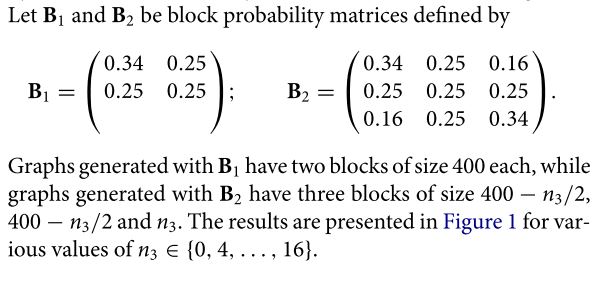

In [61]:
from IPython.display import Image, display
display(Image(filename='rdpg.jpg', embed=True))

In [13]:
%prun [rdpg(X1) for x in range(0, 100)]

Working on 0
Working on 1
[395, 395, 10]
Working on 2
[390, 390, 20]
Working on 3
[385, 385, 30]
Working on 4
[380, 380, 40]
Working on 5
[375, 375, 50]
Working on 6
[370, 370, 60]
Working on 7
[365, 365, 70]
Working on 8
[360, 360, 80]
59.844 mins


In [2]:
B1 = np.array([[0.34, 0.25],
               [0.25, 0.25]])
B2 = np.array([[0.34, 0.25, 0.16],
               [0.25, 0.25, 0.25],
               [0.16, 0.25, 0.6]])
n1 = 400
n2 = 400
n3s = [0, 10, 20, 30, 40, 50, 60, 70, 80,]

n_sims = 500

n_components = 6

T_dist = np.zeros((n_sims, len(n3s)))
T2_dist = np.zeros((n_sims, len(n3s)))

t = time.process_time()


for n_ind, n3 in enumerate(n3s):
    print('Working on {}'.format(n_ind))
    for sim in range(n_sims):
        A1 = binary_sbm([n1,n2], B1)
        if n3 == 0:
            A2 = binary_sbm([n1,n2], B1)
        else:
            communities = [(n1 - n3//2), (n2 - n3//2), n3]
            if sim == 0:
                print(communities)
#                 adj_plot(A1, title='Adjacency matrix 1')
#                 adj_plot(A2, title='Adjacency matrix 2')
            A2 = binary_sbm(communities, B2)
        if n_components is None: 
            num_dims1 = select_dimension(A1)[0][-1]
            num_dims2 = select_dimension(A2)[0][-1]
            n_components = max(num_dims1, num_dims2)
        
        spt = SemiparametricTest(n_components=n_components, test_case='scalar-rotation')
        X1hat, X2hat = spt._embed(A1, A2)
        T = spt._difference_norm(X1hat, X2hat)
        T_dist[sim, n_ind] = T
        # just making sure the order doesnt matter much
        T2 = spt._difference_norm(X2hat, X1hat)
        T2_dist[sim, n_ind] = T2
        
print('{0:.3f} mins'.format(((time.process_time() - t)/60)))
#     t = time.process_time()
#     spt = SemiparametricTest(n_bootstraps=bs, n_components=n_components)
#     spt.fit(A1, A2)
#     print('{0:.3f} mins'.format(((time.process_time() - t)/60)))
#     B1_graphs.append(A1)
#     B2_graphs.append(A2)
#     tests.append(spt)
    

6.906 mins
6.957 mins
6.747 mins
6.732 mins
6.838 mins


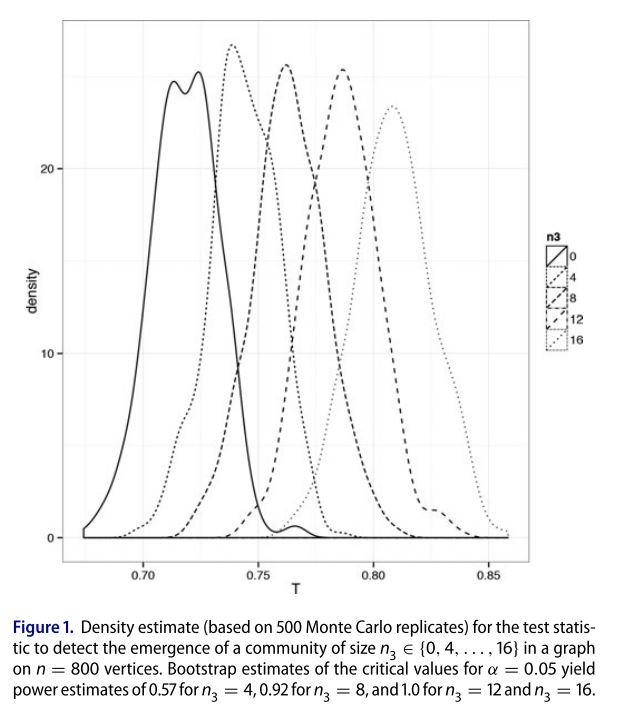

In [62]:
display(Image(filename='results.jpg', embed=True))

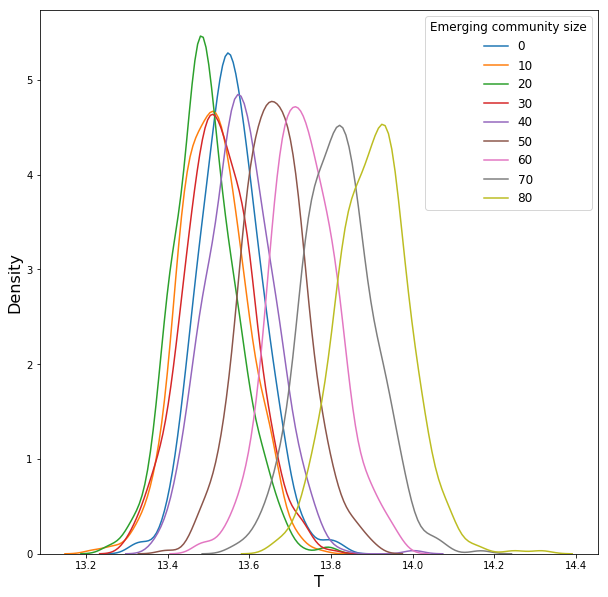

In [24]:
ax = plt.subplots(1,1,figsize=(10,10))[1]
# kde_kws = {'linestyle':'dashed'}
for idx, _ in enumerate(n3s):
#     print('n3 = {}'.format(n3s[idx]))
#     print('p = {}'.format(spt.p))
#     print('sample T statistic = {}'.format(spt.T_sample))
#     print('')
#     sns.distplot(spt.T1_bootstrap, ax=ax, hist=False, norm_hist=True, label='T1'+str(n3s[idx]), kde_kws=kde_kws)
    sns.distplot(T_dist[:,idx], ax=ax, hist=False, norm_hist=True, label=str(n3s[idx]))#label='T2'+str(n3s[idx]))
    ax.set_xlabel('T', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
l = plt.legend(title='Emerging community size', fontsize=12)
l.get_title().set_fontsize(12) 
plt.show()

# Working on Table 1 

In [2]:
def get_block_probs(eps):
    B = np.array([[0.3+eps, 0.2],
                  [0.2, 0.3+eps]])
    return B

n_components = 2
n_bootstraps = 250
sizes = [250,250]
Bx = get_block_probs(0)
epsilons = [0, 0.05, 0.1, 0.2]
nulls = []
alts = []
for eps in epsilons:
    print('Epsilon = {}'.format(eps))
    By = get_block_probs(eps)
    Ax1 = binary_sbm(sizes,Bx)
    Ax2 = binary_sbm(sizes,Bx)
#     Ay = binary_sbm(sizes,By)
    spt_null = SemiparametricTest(n_components=n_components, n_bootstraps=n_bootstraps)
    spt_null.fit(Ax1, Ax2)
#     spt_alt = SemiparametricTest(n_components=n_components, n_bootstraps=n_bootstraps)
#     spt_alt.fit(Ax1, Ay)
    nulls.append(spt_null)
#     alts.append(spt_alt)

Epsilon = 0
Epsilon = 0.05
Epsilon = 0.1
Epsilon = 0.2


3.021691285512916
0.158


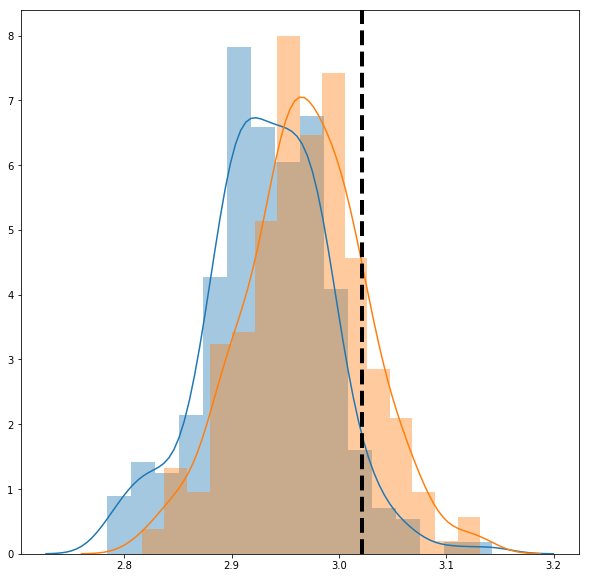

3.0512162748311438
0.134


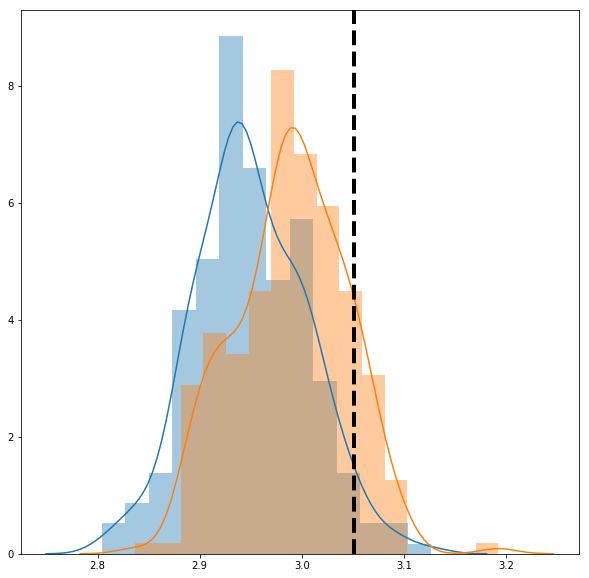

3.213300420106211
0.002


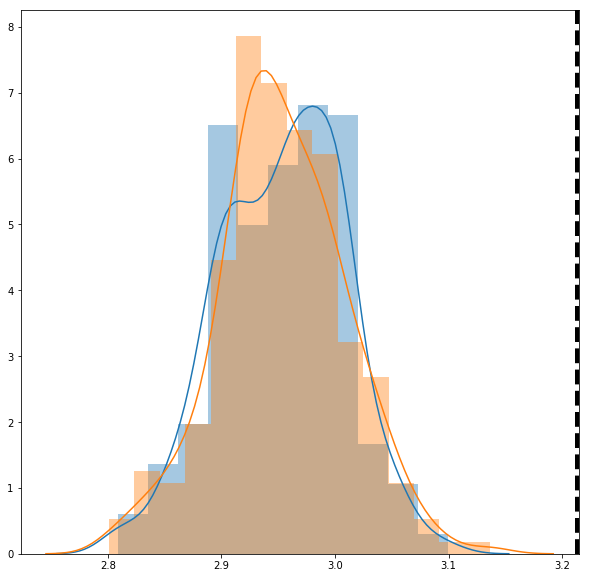

3.021932538014608
0.114


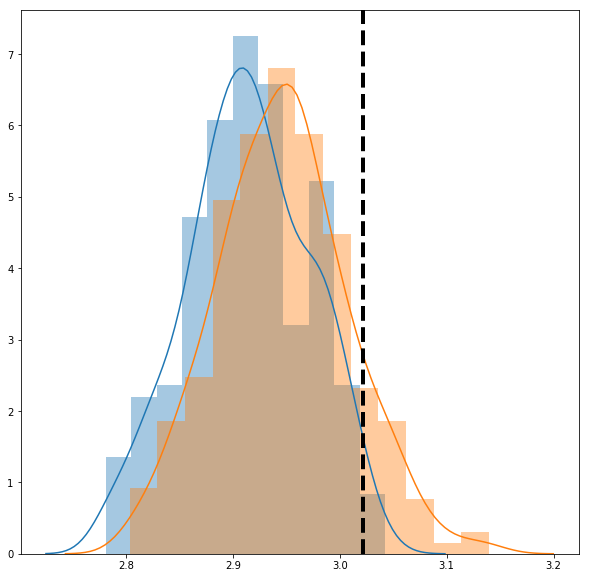

In [6]:
linestyle = '--'
color = 'black'
linewidth = 4

for test in nulls:
    print(test.T_sample)
    print(test.p)
    ax = plt.subplots(figsize=(10,10))[1]
    sns.distplot(test.T1_bootstrap, ax=ax)
    sns.distplot(test.T2_bootstrap, ax=ax)
    ax.axvline(test.T_sample, linestyle=linestyle,
               color=color, linewidth=linewidth)
    plt.show()
    


In [68]:
# Ben Pedigo
# bpedigo [at] jhu.edu
# 10.18.2018

import numpy as np

from graspy.inference.base import BaseInference
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, OmnibusEmbed, select_dimension
from graspy.simulations import rdpg_from_p, p_from_latent
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from graspy.utils import import_graph, is_symmetric

class SemiparametricTest(BaseInference):
    """
    Two sample hypothesis test for the semiparamatric problem of determining
    whether two random dot product graphs have the same latent positions.

    Parameters
    ----------
    embedding : string, { 'ase' (default), 'lse', 'omnibus'}
        String describing the embedding method to use.
        Must be one of:
        'ase'
            Embed each graph separately using adjacency spectral embedding
            and use Procrustes to align the embeddings.
        'lse'
            Embed each graph separately using laplacian spectral embedding
            and use Procrustes to align the embeddings.
        'omnibus'
            Embed all graphs simultaneously using omnibus embedding.

    n_components : None (default), or Int
        Number of embedding dimensions. If None, the optimal embedding
        dimensions are found by the Zhu and Godsi algorithm.

    test_case : string, {'rotation (default), 'scalar-rotation', 'diagonal-rotation'}
        describes the exact form of the hypothesis to test when using 'ase' or 'lse' 
        as an embedding method. Ignored if using 'omnibus'
    """

    def __init__(self, embedding='ase', n_components=None, n_bootstraps=1000, test_case='rotation',):
        if type(n_bootstraps) is not int:
            raise TypeError()
        if type(test_case) is not str:
            raise TypeError()

        if n_bootstraps < 1:
            raise ValueError('{} is invalid number of bootstraps, must be greater than 1'.format(n_bootstraps))
        if test_case not in ['rotation', 'scalar-rotation', 'diagonal-rotation']:
            raise ValueError('test_case must be one of \'rotation\', \'scalar-rotation\',\'diagonal-rotation\'')

        super().__init__(embedding=embedding, n_components=n_components,)

        self.n_bootstraps = n_bootstraps
        self.test_case = test_case

    def _bootstrap(self, X_hat):
        t_bootstrap = np.zeros(self.n_bootstraps)
        for i in range(self.n_bootstraps):
            P = p_from_latent(X_hat)
            A1_simulated = rdpg_from_p(P)
            A2_simulated = rdpg_from_p(P)
#             print(measure_connectivity(A1_simulated, [500,500]))
#             print(measure_connectivity(A2_simulated, [500,500]))
            X1_hat_simulated, X2_hat_simulated = self._embed(A1_simulated, A2_simulated)
            t_bootstrap[i] = self._difference_norm(X1_hat_simulated, X2_hat_simulated)

        return t_bootstrap

    def _difference_norm(self, X1, X2):
        if self.embedding in ['ase', 'lse']:
            if self.test_case == 'rotation':
                R = orthogonal_procrustes(X1, X2)[0]
                return np.linalg.norm(np.dot(X1, R) - X2)
            elif self.test_case == 'scalar-rotation':
                R, s = orthogonal_procrustes(X1, X2)
                return np.linalg.norm(s / np.sum(X1**2) * np.dot(X1, R) - X2)
            elif self.test_case == 'diagonal-rotation':
                raise NotImplementedError()
                normX1 = np.linalg.norm(X1, axis=1)
                normX2 =  np.linalg.norm(X2, axis=1)
                normX1[normX1 <= 1e-15] = 1
                normX2[normX2 <= 1e-15] = 1
                # print(X1)
                # print(normX1.shape)
                # print(normX1[:, None])
                X1 = np.divide(X1, normX1[:, None])
                X2 = np.divide(X1, normX2[:, None])
                R, s = orthogonal_procrustes(X1, X2)
                X2 = np.dot(X2, R)
                X2 = s / np.sum(X2**2) * X2
                # X2 = X2
                return np.linalg.norm(X1 - X2)
            elif self.test_case == 'scalar-diagonal-rotation':
                '''
                X1 = X1-np.mean(X1, 0)
                X2 = X1-np.mean(X2, 0)
                normX1 = np.linalg.norm(X1)
                normX2 =  np.linalg.norm(X2)
                X1 /= normX1
                X2 /= normX2
                R,s = orthogonal_procrustes(X1, X2)
                X2 = np.dot(X2, R.T)*s
                return np.linalg.norm(X1 - X2)
                '''
                mx1, mx2, disparity = procrustes(X1,X2)
                return disparity
        else:
            return np.linalg.norm(X1 - X2)

    def _embed(self, A1, A2):
        if self.embedding not in ['ase', 'lse', 'omnibus']:
            raise ValueError('Invalid embedding method "{}"'.format(self.embedding))
        if self.embedding == 'ase':
            X1_hat = AdjacencySpectralEmbed(k=self.n_components).fit_transform(A1)
            X2_hat = AdjacencySpectralEmbed(k=self.n_components).fit_transform(A2)
        elif self.embedding == 'lse':
            X1_hat = LaplacianSpectralEmbed(k=self.n_components).fit_transform(A1)
            X2_hat = LaplacianSpectralEmbed(k=self.n_components).fit_transform(A2)
        elif self.embedding == 'omnibus':
            X_hat_compound = OmnibusEmbed(k=self.n_components).fit_transform((A1, A2))
            X1_hat = X_hat_compound[:A1.shape[0],:]
            X2_hat = X_hat_compound[A2.shape[0]:,:]

        return (X1_hat, X2_hat)

    def fit(self, A1, A2):
        A1 = import_graph(A1)
        A2 = import_graph(A2)
        if not is_symmetric(A1) or not is_symmetric(A2):
            raise NotImplementedError() # TODO asymmetric case
        if A1.shape != A2.shape:
            raise ValueError('Input matrices do not have matching dimensions')
        # need to make sure A1 and A2 will both be embeded in same num dims
        # could be an argument for doing this in init but I think it makes sense here
        if self.n_components is None:
            num_dims1 = select_dimension(A1)[0][-1]
            num_dims2 = select_dimension(A2)[0][-1]
            self.n_components = max(num_dims1, num_dims2)
        X_hats = self._embed(A1, A2)
        T_sample = self._difference_norm(X_hats[0], X_hats[1])
        T1_bootstrap = self._bootstrap(X_hats[0])
        T2_bootstrap = self._bootstrap(X_hats[1])

        # Continuity correction - note that the +0.5 causes p > 1 sometimes # TODO 
        p1 = (len(T1_bootstrap[T1_bootstrap >= T_sample]) + 0.5) / self.n_bootstraps
        p2 = (len(T2_bootstrap[T2_bootstrap >= T_sample]) + 0.5) / self.n_bootstraps

        p = max(p1, p2)

        # TODO : what to store as fields here, or make _private fields
        # at least for the sake of testing, I'm going to keep everything

        self.T1_bootstrap = T1_bootstrap
        self.T2_bootstrap = T2_bootstrap
        self.T_sample = T_sample
        self.p1 = p1
        self.p2 = p2
        self.p = p

        return p

def measure_connectivity(A, sizes):
    cstart = 0
    rstart = 0
    connectivity = np.zeros((len(sizes), len(sizes)))
    for cidx, size in enumerate(sizes): 
        for ridx in range(len(sizes)):
            p = np.mean(A[rstart:rstart+size, cstart:cstart+size])
            connectivity[ridx, cidx] = p
            rstart += size
        cstart += size
        rstart = 0
    return connectivity

In [3]:
def get_block_probs(eps):
    B = np.array([[0.3+eps, 0.2],
                  [0.2, 0.3+eps]])
    return B

n_components = 2
n_bootstraps = 250
sizes = [500,500]
Bx = get_block_probs(0)
epsilons = [0, 0.05, 0.1, 0.2]
nulls = []
alts = []
for eps in epsilons:
    print('Epsilon = {}'.format(eps))
    By = get_block_probs(eps)
    Ax1 = binary_sbm(sizes,Bx)
    Ax2 = binary_sbm(sizes,Bx)
    Ay = binary_sbm(sizes,By)
#     print('Original:')
#     print(measure_connectivity(Ax1, [500,500]))
#     print(measure_connectivity(Ax2, [500,500]))
#     print(measure_connectivity(Ay, [500,500]))
#     print('')
#     print('Null:')
    spt_null = SemiparametricTest(n_components=n_components, n_bootstraps=n_bootstraps)
#     spt_null.fit(Ax1, Ax2)
    spt_null._difference_norm(Ax1, Ax2)
#     print('')
#     print('Alt:')
#     spt_alt = SemiparametricTest(n_components=n_components, n_bootstraps=n_bootstraps)
#     spt_alt.fit(Ax1, Ay)
#     nulls.append(spt_null)
#     alts.append(spt_alt)
#     print('')

Epsilon = 0
Epsilon = 0.05
Epsilon = 0.1
Epsilon = 0.2


In [29]:
n_components = 2
A = Ax1
Xhat0 = AdjacencySpectralEmbed(k=n_components).fit_transform(A)
procrustes_norms = []
spt = SemiparametricTest(n_components=n_components)
for i in range(10):
    ase = AdjacencySpectralEmbed(k=n_components)
    Xhat = ase.fit_transform(A)
    procrustes_norms.append(spt._difference_norm(Xhat0, Xhat))
    Anew = rdpg_from_latent(Xhat)
    Anew_clipped = rdpg_from_latent(Xhat, Xhat0)
    A = Anew

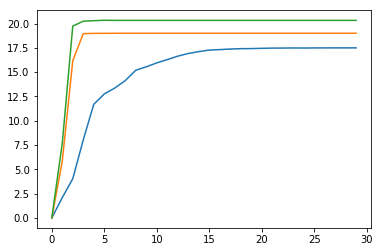

In [31]:
plt.plot(np.array(procrustes_norms))
plt.plot(np.array(procrustes_norms4))
plt.plot(np.array(procrustes_norms6))
plt.show()

In [62]:
n_components = 4
n_bootstraps = 250
nulls = []
alts = []
X = np.random.uniform(size=(600,4))
A1 = rdpg_from_latent(X)
A2 = rdpg_from_latent(X)

spt_null = SemiparametricTest(n_components=n_components, n_bootstraps=n_bootstraps)
X1e, X2e = spt_null._embed(A1, A2)
diff = spt_null._difference_norm(X1,X2)
diffe = spt_null._difference_norm(X1e, X2e) 

In [ ]:
t1 = spt_null._bootstrap(A1)  
t2 = spt_null._bootstrap(A2)

9.30531868087986

In [59]:
diff

8.129340559806025

In [60]:
diffe

5.683791935416892

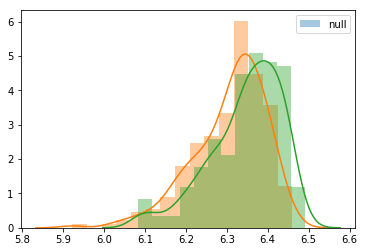

In [58]:
sns.distplot(t1)
sns.distplot(t2)
plt.legend()